In [ ]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import ee
import geemap


# Preparing the field data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GEE config

In [ ]:
from google.colab import auth
auth.authenticate_user(project_id='vibrant-chain-457610-f6')

In [ ]:
import ee
ee.Authenticate()  # Run this to authenticate your account
ee.Initialize()

# Region of interest

In [ ]:
import geopandas as gpd
import geemap
from shapely.geometry import mapping
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load the shapefile
shapefile_path = '/content/drive/My Drive/GIS/EdaratKol.shp'
edaratkol = gpd.read_file(shapefile_path)

# Ensure the CRS is WGS84 (EPSG:4326)
if edaratkol.crs != "EPSG:4326":
    edaratkol = edaratkol.to_crs("EPSG:4326")

# Check if the polygon is valid
edaratkol = edaratkol[edaratkol.is_valid]

# Convert the GeoDataFrame to an Earth Engine FeatureCollection
def gdf_to_ee(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = ee.Geometry(mapping(row['geometry']))  # Convert geometry to Earth Engine format
        props = row.drop('geometry').to_dict()  # Get properties
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

edaratkol_fc = gdf_to_ee(edaratkol)

# Initialize the map
m = geemap.Map()

# Add Google Satellite basemap
m.add_basemap("SATELLITE")

# Add the polygon with a custom style
polygon_style = {
    'color': 'red',       # Outline color
    'fillColor': 'yellow',  # Fill color
    'fillOpacity': 0.3    # Transparency
}
m.addLayer(edaratkol_fc, polygon_style, "EdaratKol Polygon")

# Center the map on the polygon
m.centerObject(edaratkol_fc, 10)

# Display the map
m


Map(center=[36.75844018634709, 52.24745554853265], controls=(WidgetControl(options=['position', 'transparent_b…

# GEDI collection and export

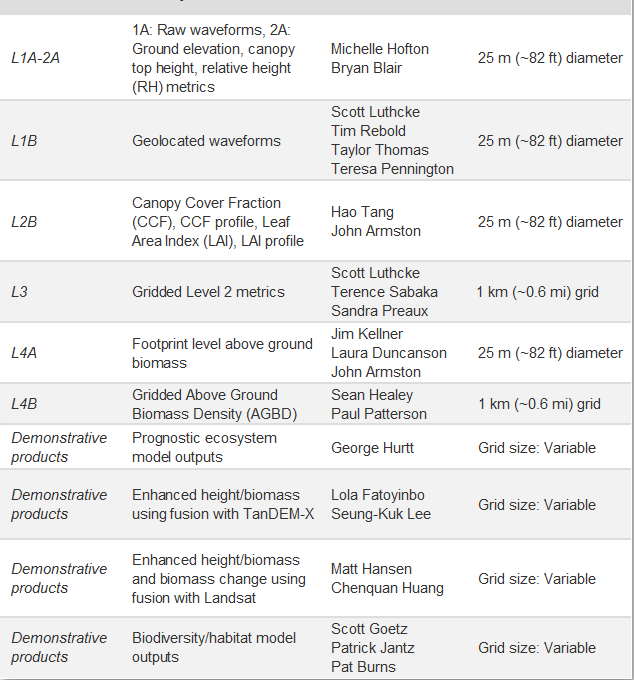

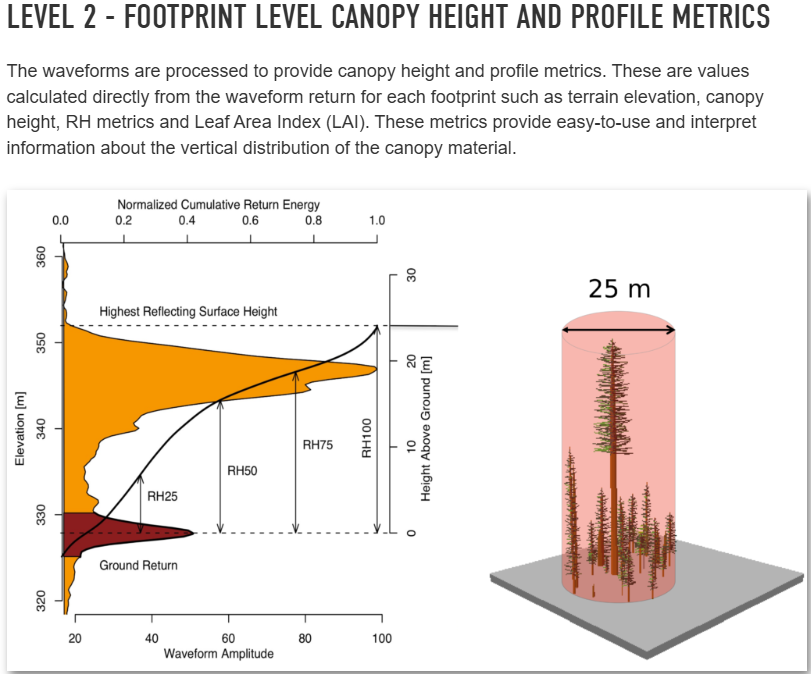

In [ ]:

# Define the list of selected fields
selected_fields = [
    'rh5', 'rh10', 'rh15', 'rh20', 'rh25', 'rh30', 'rh35', 'rh40', 'rh45', 'rh50',
    'rh55', 'rh60', 'rh65', 'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95', 'rh100','quality_flag','sensitivity',
]

# Load and filter GEDI data for both 2022 and 2023 (April 15 - September 15)
gedi = (
    ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY')
    .select(selected_fields)
    .filterBounds(edaratkol_fc)  # Ensure it covers the study area
    .filterDate('2019-01-01', '2021-12-28')  # Filter for spring-summer 2022
    .map(lambda img: img.clip(edaratkol_fc))  # Clip each image to the study area
)


# Count the number of image tiles
gedi_tile_count = gedi.size()

# Print the result
print("Number of Tiles:", gedi_tile_count.getInfo())


Number of Tiles: 99


In [ ]:
# Convert footprints into vector points for further processing
total_footprint_points = gedi.map(
    lambda img: img.sampleRegions(
        collection=edaratkol_fc,  # Extract values for each footprint in study area
        scale=25,  # GEDI footprint size
        geometries=True  # Keep geometry (latitude/longitude) for each footprint
    )
).flatten()  # Flatten the collection of feature lists into one FeatureCollection


# Print one example footprint to verify
print(total_footprint_points.first().getInfo())

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [51.18763802514024, 36.22830394615058]}, 'id': '201904_048E_036N_0_0', 'properties': {'Hectares': 20712.5118284, 'layer': 'Nowshahr', 'quality_flag': 1, 'rh10': -5.159999847412109, 'rh100': 12.880000114440918, 'rh15': -4, 'rh20': -3.069999933242798, 'rh25': -2.240000009536743, 'rh30': -1.5299999713897705, 'rh35': -0.8899999856948853, 'rh40': -0.28999999165534973, 'rh45': 0.25999999046325684, 'rh5': -6.590000152587891, 'rh50': 0.8600000143051147, 'rh55': 1.4600000381469727, 'rh60': 2.0899999141693115, 'rh65': 2.690000057220459, 'rh70': 3.369999885559082, 'rh75': 4.039999961853027, 'rh80': 4.75, 'rh85': 5.650000095367432, 'rh90': 6.929999828338623, 'rh95': 8.84000015258789, 'sensitivity': 0.9381229877471924}}


In [ ]:
# Function to Count footprints
def count_footprints(image):
    count = image.reduceRegion(
        reducer=ee.Reducer.count(),  # Count valid footprints in each image
        geometry=edaratkol_fc,  # Study area
        scale=25,  # GEDI footprint size ~25m
        maxPixels=1e9,  # Allow processing of large areas
        bestEffort=True  # Automatically adjust resolution to fit within maxPixels
    ).get('rh95')  # Use any non-null band (e.g., rh95)

    return ee.Feature(None, {'count': count})  # Store count as a feature


In [ ]:
# Map the function over the filtered collection and sum the results
footprint_counts = gedi.map(count_footprints)

# Sum all footprints
footprint_counts = footprint_counts.aggregate_sum('count')

# Print the final count
print("Total GEDI footprints:", footprint_counts.getInfo())

Total GEDI footprints: 5895988


In [ ]:
# Apply footprint-level filtering (use updateMask to remove low-quality footprints and invalid heights)
gedi_filtered = gedi.map(
    lambda img: img.updateMask(
        img.select('quality_flag').eq(1)
        .And(img.select('sensitivity').gt(0.95))
    )
)

In [ ]:
# Map the function over the filtered collection and sum the results
filteredfootprint_counts = gedi_filtered.map(count_footprints)

# Sum all footprints
filteredfootprint_counts = filteredfootprint_counts.aggregate_sum('count')

# Print the final count
print("Total GEDI footprints after filtering:", filteredfootprint_counts.getInfo())

Total GEDI footprints after filtering: 1739681


In [ ]:
# Function to extract latitude and longitude
def add_lat_lon(feature):
    coords = feature.geometry().coordinates()
    return feature.set({
        'longitude': coords.get(0),
        'latitude': coords.get(1)
    }).select(selected_fields)

# Add lat/lon properties and filter columns
gedi_filtered_latlon = gedi_filtered.map(add_lat_lon)

In [ ]:
# First, sample footprints from filtered GEDI
def safe_sample(img):
    sampled = img.sampleRegions(
        collection=edaratkol_fc,
        scale=25,
        geometries=True
    )
    return ee.FeatureCollection(ee.Algorithms.If(
        sampled.size().gt(0),
        sampled,
        ee.FeatureCollection([])
    ))

# Sample filtered GEDI data
total_filtered_footprint_points = gedi_filtered.map(safe_sample).flatten()

# Now define your function to add lat/lon
def add_lat_lon(feature):
    coords = feature.geometry().coordinates()
    return feature.set({
        'longitude': coords.get(0),
        'latitude': coords.get(1)
    }).select(selected_fields + ['longitude', 'latitude'])

# Now apply it on the FeatureCollection (points)
gedi_filtered_latlon = total_filtered_footprint_points.map(add_lat_lon)

# Check
print(gedi_filtered_latlon.first().getInfo())


{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [51.22853078614288, 36.22800744333104]}, 'id': '201904_048E_036N_0_0', 'properties': {'latitude': 36.22800744333104, 'longitude': 51.22853078614288, 'quality_flag': 1, 'rh10': -3.700000047683716, 'rh100': 8.609999656677246, 'rh15': -2.990000009536743, 'rh20': -2.4700000286102295, 'rh25': -1.9800000190734863, 'rh30': -1.5299999713897705, 'rh35': -1.159999966621399, 'rh40': -0.7799999713897705, 'rh45': -0.4099999964237213, 'rh5': -4.789999961853027, 'rh50': -0.029999999329447746, 'rh55': 0.33000001311302185, 'rh60': 0.7099999785423279, 'rh65': 1.1200000047683716, 'rh70': 1.4900000095367432, 'rh75': 1.940000057220459, 'rh80': 2.430000066757202, 'rh85': 3.0299999713897705, 'rh90': 3.8499999046325684, 'rh95': 5.090000152587891, 'sensitivity': 0.964497983455658}}


In [ ]:

# Export to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=gedi_filtered_latlon,
    description='Filtered_GEDI_Footprints',
    folder='4_V_Akhavan',
    fileNamePrefix='Filtered_GEDI_Footprints',
    fileFormat='CSV'
)

# Start the export task
export_task.start()

print("Export task started. Check the 'Tasks' tab in GEE to monitor progress.")


Export task started. Check the 'Tasks' tab in GEE to monitor progress.


In [ ]:
export_task.status()

{'state': 'COMPLETED',
 'description': 'Filtered_GEDI_Footprints',
 'priority': 100,
 'creation_timestamp_ms': 1745813148977,
 'update_timestamp_ms': 1745814455194,
 'start_timestamp_ms': 1745813151465,
 'task_type': 'EXPORT_FEATURES',
 'destination_uris': ['https://drive.google.com/#folders/1LHIdpVY25Ii7b7rNAg0eUH-RRKHuGys4'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 244.5053253173828,
 'id': 'Z2U4FWWODQBKPJ2LIPQLXSV5',
 'name': 'projects/vibrant-chain-457610-f6/operations/Z2U4FWWODQBKPJ2LIPQLXSV5'}